In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl   
import warnings
warnings.filterwarnings('ignore')

sns.set_style('darkgrid')

%matplotlib inline

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

mpl.rc('axes',unicode_minus=False)

# Data

+ https://www.kaggle.com/datasets/teejmahal20/airline-passenger-satisfaction

< Columns Info >
+ Gender: Gender of the passengers (Female, Male)
+ Customer Type: The customer type (Loyal customer, disloyal customer)
+ Age: The actual age of the passengers
+ Type of Travel: Purpose of the flight of the passengers (Personal Travel, Business Travel)
+ Class: Travel class in the plane of the passengers (Business, Eco, Eco Plus)
+ Flight distance: The flight distance of this journey
+ Inflight wifi service: Satisfaction level of the inflight wifi service (0:Not Applicable;1-5)
+ Departure/Arrival time convenient: Satisfaction level of Departure/Arrival time convenient
+ Ease of Online booking: Satisfaction level of online booking
+ Gate location: Satisfaction level of Gate location
+ Food and drink: Satisfaction level of Food and drink
+ Online boarding: Satisfaction level of online boarding
+ Seat comfort: Satisfaction level of Seat comfort
+ Inflight entertainment: Satisfaction level of inflight entertainment
+ On-board service: Satisfaction level of On-board service
+ Leg room service: Satisfaction level of Leg room service
+ Baggage handling: Satisfaction level of baggage handling
+ Check-in service: Satisfaction level of Check-in service
+ Inflight service: Satisfaction level of inflight service
+ Cleanliness: Satisfaction level of Cleanliness
+ Departure Delay in Minutes: Minutes delayed when departure
+ Arrival Delay in Minutes: Minutes delayed when Arrival
+ Satisfaction: Airline satisfaction level(Satisfaction, neutral or dissatisfaction)

In [88]:
from lightgbm import LGBMClassifier, plot_importance
from xgboost import XGBClassifier, plot_importance
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import LabelEncoder

In [3]:
train=pd.read_csv('/root/MLAI-Project-Team3/AirplaneDataset/train.csv')
test=pd.read_csv('/root/MLAI-Project-Team3/AirplaneDataset/test.csv')

train=train.drop(['Unnamed: 0', 'id'],axis=1).reset_index(drop=True)
test=test.drop(['Unnamed: 0', 'id'],axis=1).reset_index(drop=True)
train.head()

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,3,1,...,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,Male,disloyal Customer,25,Business travel,Business,235,3,2,3,3,...,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,Female,Loyal Customer,26,Business travel,Business,1142,2,2,2,2,...,5,4,3,4,4,4,5,0,0.0,satisfied
3,Female,Loyal Customer,25,Business travel,Business,562,2,5,5,5,...,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,Male,Loyal Customer,61,Business travel,Business,214,3,3,3,3,...,3,3,4,4,3,3,3,0,0.0,satisfied


In [4]:
def preprocess(data):
    
    data=data.dropna().reset_index(drop=True)
    label_list=['Gender','Customer Type','Type of Travel','Class','satisfaction']
    
    for i in label_list:
        y1=data[[i]].values.tolist()
        encoder=LabelEncoder()
        encoder.fit(y1)
        label1=encoder.transform(y1)
        data[i]=label1
        
    return data

In [5]:
train_clean=preprocess(train)
train_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103594 entries, 0 to 103593
Data columns (total 23 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Gender                             103594 non-null  int64  
 1   Customer Type                      103594 non-null  int64  
 2   Age                                103594 non-null  int64  
 3   Type of Travel                     103594 non-null  int64  
 4   Class                              103594 non-null  int64  
 5   Flight Distance                    103594 non-null  int64  
 6   Inflight wifi service              103594 non-null  int64  
 7   Departure/Arrival time convenient  103594 non-null  int64  
 8   Ease of Online booking             103594 non-null  int64  
 9   Gate location                      103594 non-null  int64  
 10  Food and drink                     103594 non-null  int64  
 11  Online boarding                    1035

# EDA

In [6]:
# 데이터의 관측치, 컬럼유형, 결측률 등의 일반적인 정보를 정리함
def str_summary(df, pred=None): 
  obs = df.shape[0]
  types = df.dtypes
  counts = df.apply(lambda x: x.count())
  uniques = df.apply(lambda x: [x.unique()]).T.squeeze()
  nulls = df.apply(lambda x: x.isnull().sum())
  distincts = df.apply(lambda x: x.unique().shape[0])
  missing_ratio = (df.isnull().sum()/ obs) * 100
  
  print('Data shape:', df.shape)
    
  cols = ['Types', 'Counts', 'Distincts', 'Nulls', 'Missing_ratio', 'Uniques']
  structure = pd.concat([types, counts, distincts, nulls, missing_ratio, uniques], axis = 1, sort=True)

  structure.columns = cols
  
  print('___________________________\nData types:\n',structure.Types.value_counts())
  print('___________________________')

  return structure

data_summary = str_summary(train)
data_summary

Data shape: (103904, 23)
___________________________
Data types:
 int64      17
object      5
float64     1
Name: Types, dtype: int64
___________________________


,Types,Counts,Distincts,Nulls,Missing_ratio,Uniques
Age,int64,103904,75,0,0.000000,"[13, 25, 26, 61, 47, 52, 41, 20, 24, 12, 53, 3..."
Arrival Delay in Minutes,float64,103594,456,310,0.298352,"[18.0, 6.0, 0.0, 9.0, 23.0, 8.0, 35.0, 51.0, 1..."
Baggage handling,int64,103904,5,0,0.000000,"[4, 3, 5, 1, 2]"
Checkin service,int64,103904,6,0,0.000000,"[4, 1, 3, 5, 2, 0]"
Class,object,103904,3,0,0.000000,"[Eco Plus, Business, Eco]"
Cleanliness,int64,103904,6,0,0.000000,"[5, 1, 2, 3, 4, 0]"
Customer Type,object,103904,2,0,0.000000,"[Loyal Customer, disloyal Customer]"
Departure Delay in Minutes,int64,103904,446,0,0.000000,"[25, 1, 0, 11, 9, 4, 28, 43, 49, 7, 17, 52, 54..."
Departure/Arrival time convenient,int64,103904,6,0,0.000000,"[4, 2, 5, 3, 1, 0]"
Ease of Online booking,int64,103904,6,0,0.000000,"[3, 2, 5, 4, 1, 0]"


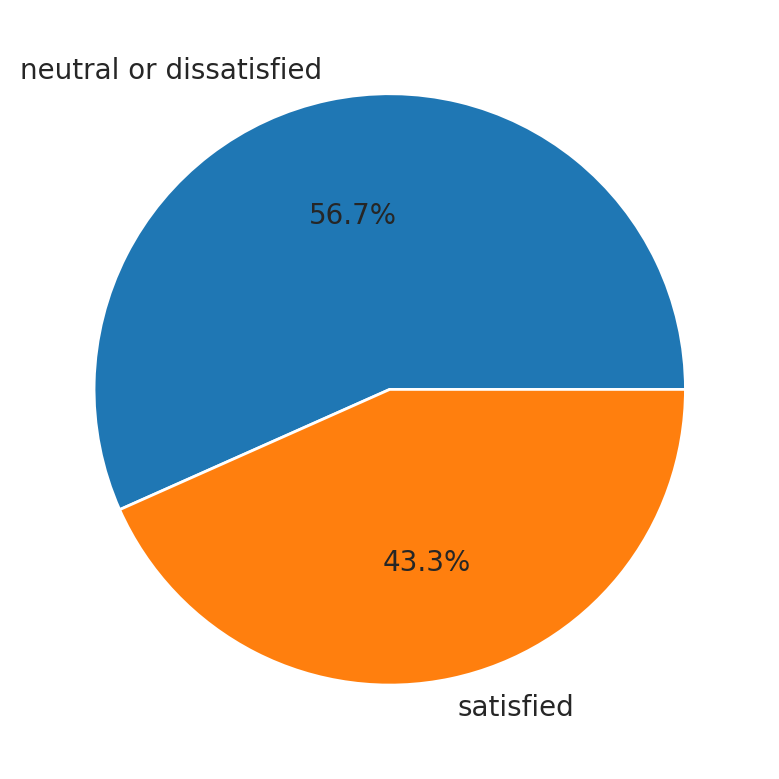

In [10]:
# Label Distribution
labels = train.satisfaction.unique()
ratio = train.satisfaction.value_counts(normalize=True) * 100

plt.pie(ratio, labels=labels, autopct='%.1f%%')
plt.show()


In [61]:
rated_features = ['Inflight wifi service', 'Departure/Arrival time convenient', 'Ease of Online booking', 'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort', 'Inflight entertainment', 'On-board service', 'Leg room service', 'Baggage handling', 'Checkin service', 'Inflight service', 'Cleanliness']

display(pd.pivot_table(data=train, index='Class',values=rated_features,aggfunc='mean'))

display(pd.pivot_table(data=train, index='satisfaction',values=rated_features,aggfunc='mean'))

,Baggage handling,Checkin service,Cleanliness,Departure/Arrival time convenient,Ease of Online booking,Food and drink,Gate location,Inflight entertainment,Inflight service,Inflight wifi service,Leg room service,On-board service,Online boarding,Seat comfort
Class,,,,,,,,,,,,,,
Business,3.842907,3.519178,3.477600,2.905910,2.913964,3.323165,2.982926,3.635437,3.844579,2.775315,3.644498,3.679472,3.716541,3.760858
Eco,3.450551,3.122002,3.108097,3.199123,2.605241,3.086277,2.971954,3.098256,3.463921,2.675067,3.085720,3.120355,2.812985,3.138838
Eco Plus,3.363758,3.017214,3.130771,3.217507,2.661996,3.122631,2.967574,3.141713,3.388444,2.767948,3.061382,3.047638,2.889245,3.183747


,Baggage handling,Checkin service,Cleanliness,Departure/Arrival time convenient,Ease of Online booking,Food and drink,Gate location,Inflight entertainment,Inflight service,Inflight wifi service,Leg room service,On-board service,Online boarding,Seat comfort
satisfaction,,,,,,,,,,,,,,
neutral or dissatisfied,3.375991,3.042952,2.936123,3.129112,2.546850,2.95805,2.976121,2.894156,3.388814,2.399633,2.990812,3.019158,2.656125,3.036295
satisfied,3.966396,3.646041,3.744342,2.970305,3.031582,3.52131,2.977879,3.964931,3.969461,3.161288,3.822143,3.857324,4.027474,3.966530


(0.0, 100.0)

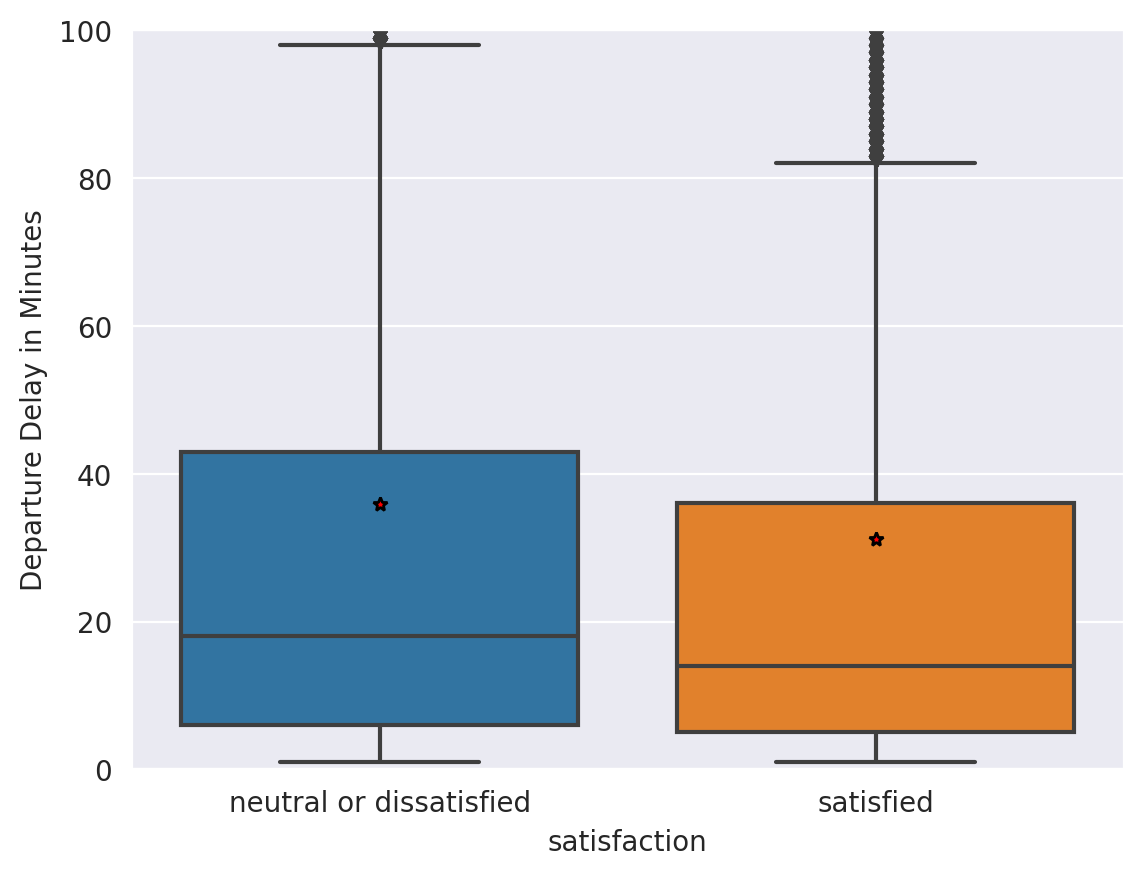

In [32]:
sns.boxplot(x=train[train['Departure Delay in Minutes']!=0]['satisfaction'],
            y=train['Departure Delay in Minutes'],
            showmeans=True,
            meanprops={"marker":"*",
                       "markerfacecolor":"red", 
                       "markeredgecolor":"black",
                      "markersize":"5"})
plt.ylim(0,100)

(0.0, 100.0)

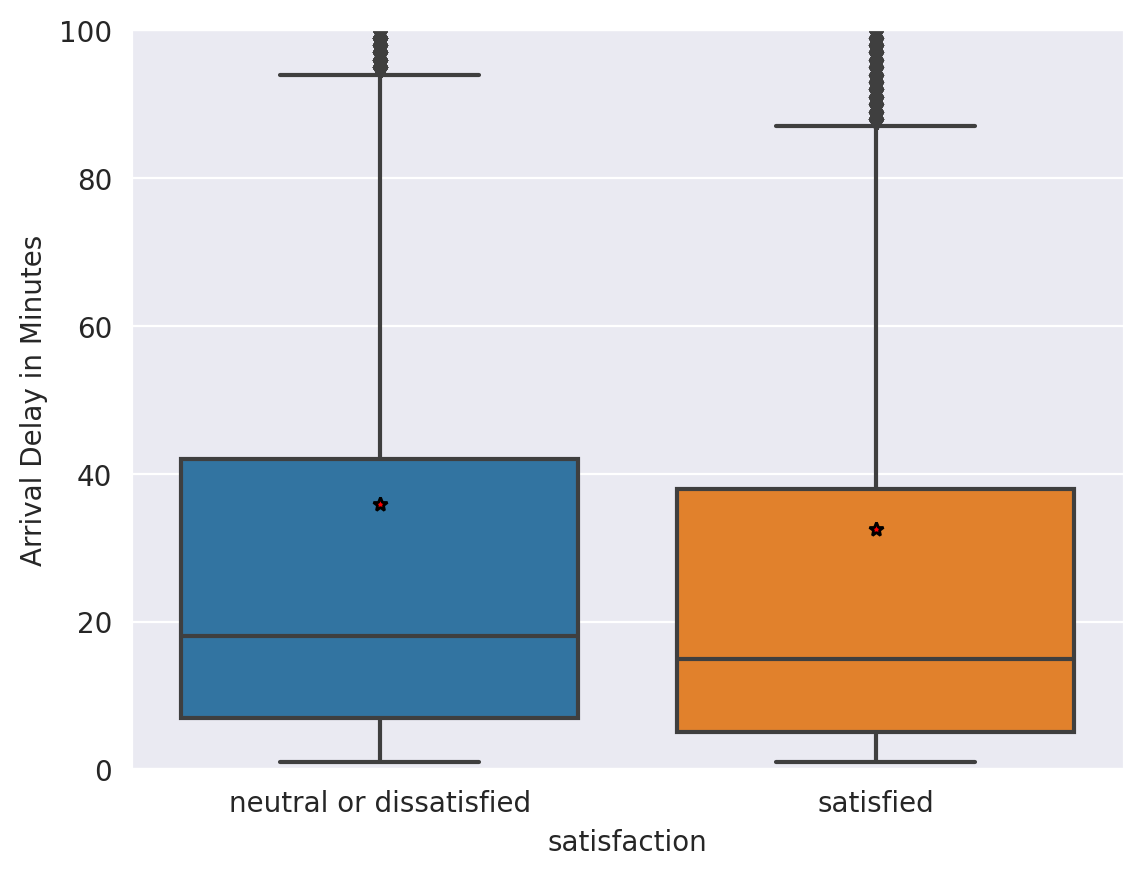

In [30]:
sns.boxplot(x=train[train['Arrival Delay in Minutes']!=0]['satisfaction'],
            y=train['Arrival Delay in Minutes'],
            showmeans=True,
            meanprops={"marker":"*",
                       "markerfacecolor":"red", 
                       "markeredgecolor":"black",
                      "markersize":"5"})
plt.ylim(0,100)

<AxesSubplot: xlabel='satisfaction', ylabel='Flight Distance'>

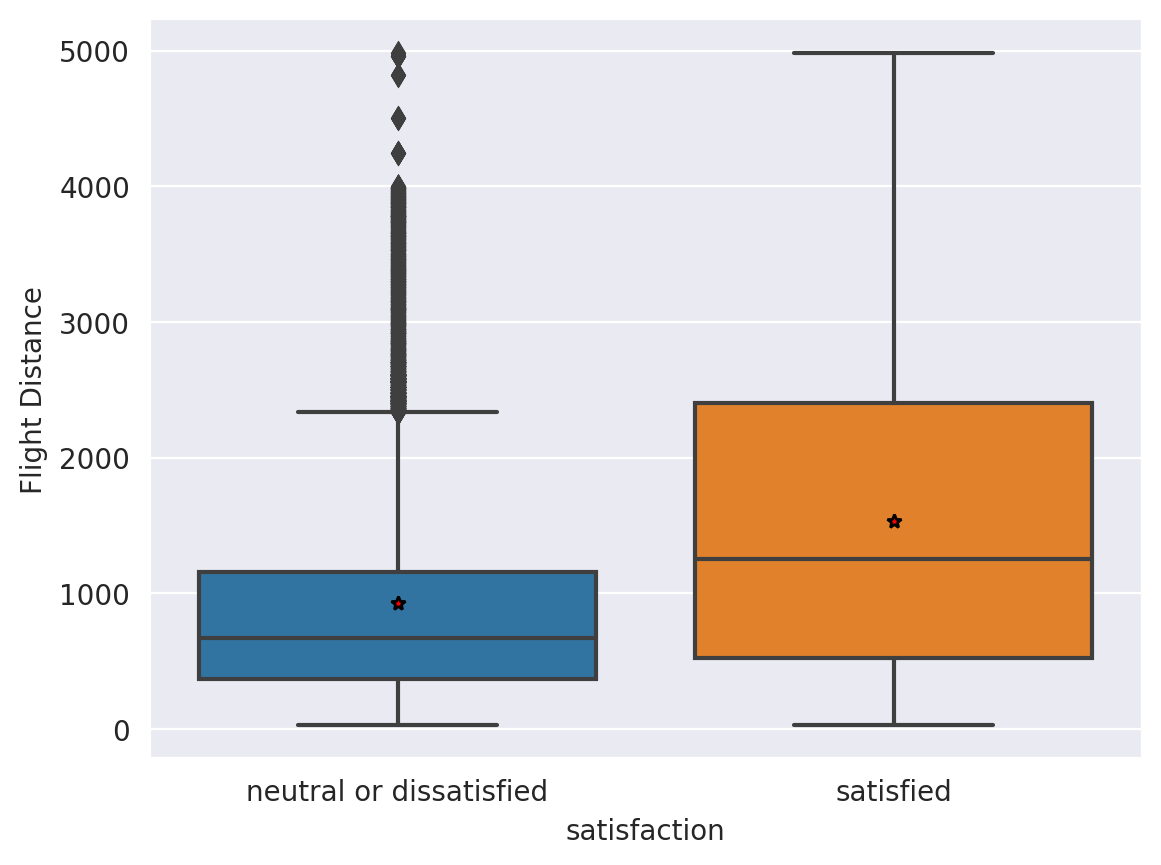

In [26]:
sns.boxplot(x=train['satisfaction'],y=train['Flight Distance'],
            showmeans=True,
            meanprops={"marker":"*",
                       "markerfacecolor":"red", 
                       "markeredgecolor":"black",
                      "markersize":"5"})

<AxesSubplot: xlabel='satisfaction', ylabel='Age'>

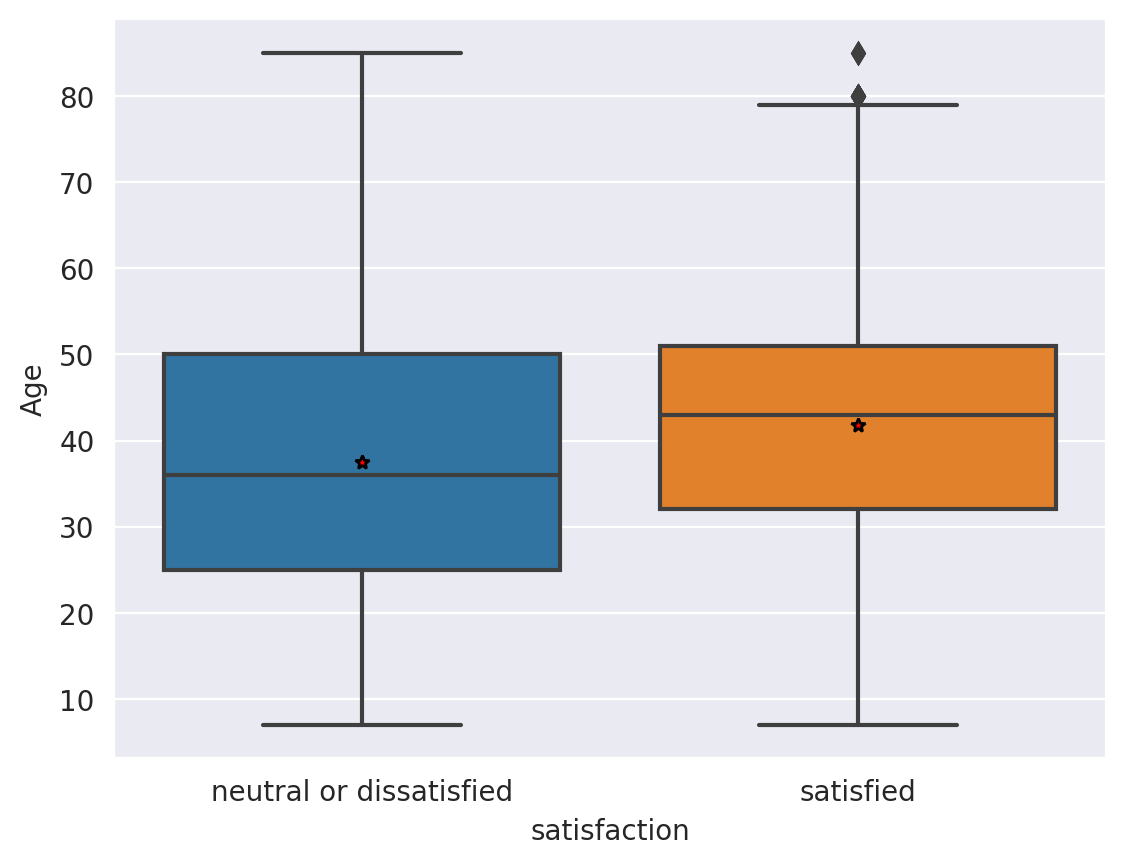

In [31]:
sns.boxplot(x=train['satisfaction'],y=train['Age'],
            showmeans=True,
            meanprops={"marker":"*",
                       "markerfacecolor":"red", 
                       "markeredgecolor":"black",
                      "markersize":"5"})

# Modeling

In [95]:
def train_kfold(X, Y, model_type, num_splits=5):
    kfold=KFold(n_splits=num_splits)
    cv_score=[]

    x=X
    y=Y
    
    if model_type=='xgb':
        model = XGBClassifier()
    elif model_type=='cat':
        model = CatBoostClassifier(iterations=100)
    elif model_type=='rf':
        model = RandomForestClassifier()
    elif model_type=='lgbm':
        model = LGBMClassifier()

    n_iter=0
    for train_index, test_index in kfold.split(x):
        x_train, x_test=x.iloc[train_index],x.iloc[test_index]
        y_train, y_test=y[train_index],y[test_index]
        
        if model_type=='cat':
            model.fit(x_train, y_train, 
                    cat_features=['Gender','Customer Type','Type of Travel','Class'], verbose=False)
        else:
            model.fit(x_train, y_train)
        y_pred_train=model.predict(x_train)
        y_pred_test=model.predict(x_test)
        
        n_iter=n_iter+1
        
        acc_train=accuracy_score(y_train,y_pred_train)
        acc_test=accuracy_score(y_test,y_pred_test)
        cv_score.append(acc_test)
        
        print("Modeling ",n_iter,"st")
        print('train set accuracy_score: ',acc_train)
        print('test set accuracy_score: ',acc_test)
        print("-----------------------------------------")
        
    print('Mean test set accuracy_score: ',np.mean(cv_score))

In [ ]:
X = train_clean.drop('satisfaction',axis=1)
Y = train_clean['satisfaction']

test_clean = preprocess(test)
X_test = test_clean.drop('satisfaction',axis=1)
Y_test = test_clean['satisfaction']

## CatBoost

In [71]:
train_kfold(X, Y, 'cat')

Modeling  1 st
train set accuracy_score:  0.9720180995475113
test set accuracy_score:  0.9611467734929292
-----------------------------------------
Modeling  2 st
train set accuracy_score:  0.9720904977375565
test set accuracy_score:  0.9621120710458999
-----------------------------------------
Modeling  3 st
train set accuracy_score:  0.9724404223227753
test set accuracy_score:  0.9622568656788455
-----------------------------------------
Modeling  4 st
train set accuracy_score:  0.9732126696832579
test set accuracy_score:  0.9623533954341426
-----------------------------------------
Modeling  5 st
train set accuracy_score:  0.9716202519426613
test set accuracy_score:  0.9642339994207935
-----------------------------------------
Mean test set accuracy_score:  0.9624206210145221


In [35]:
model=CatBoostClassifier()
param={'learning_rate': [0.05, 0.1, 0.5], 'depth': [4, 6, 8], 'l2_leaf_reg': [1, 3, 5], 'iterations':[100, 200]}

grid_model=GridSearchCV(model, param_grid=param, cv=5, scoring='accuracy')
grid_model.fit(X, Y, cat_features=['Gender','Customer Type','Type of Travel','Class'], verbose=False)
result=pd.DataFrame(grid_model.cv_results_)

grid_model.best_params_

{'depth': 8, 'iterations': 200, 'l2_leaf_reg': 1, 'learning_rate': 0.1}

In [75]:
cat = CatBoostClassifier(**{'depth': 8, 'iterations': 200, 'l2_leaf_reg': 1, 'learning_rate': 0.1})
cat.fit(X, Y, verbose=False)
cat_pred = cat.predict(X_test)

accuracy_score(Y_test,cat_pred)

0.9643533001197234

## XGBOOST

In [99]:
train_kfold(X, Y, 'xgb')

Modeling  1 st
train set accuracy_score:  0.9774841628959277
test set accuracy_score:  0.9610985086152807
-----------------------------------------
Modeling  2 st
train set accuracy_score:  0.9773755656108597
test set accuracy_score:  0.9626912495776824
-----------------------------------------
Modeling  3 st
train set accuracy_score:  0.9756742081447963
test set accuracy_score:  0.9617259520247117
-----------------------------------------
Modeling  4 st
train set accuracy_score:  0.976289592760181
test set accuracy_score:  0.9642357256624354
-----------------------------------------
Modeling  5 st
train set accuracy_score:  0.9769776533616488
test set accuracy_score:  0.9639443961772372
-----------------------------------------
Mean test set accuracy_score:  0.9627391664114695


In [76]:
model=XGBClassifier()

param={'max_depth':[3,5,8],'scale_pos_weight':[1,3,5],'n_estimators':[200,300],'min_child_weight':[1,2,3]}
grid_model=GridSearchCV(model,param_grid=param, cv=5,scoring='accuracy')
grid_model.fit(X,Y)

result_xgb=pd.DataFrame(grid_model.cv_results_)
grid_model.best_params_

{'max_depth': 5,
 'min_child_weight': 3,
 'n_estimators': 200,
 'scale_pos_weight': 1}

In [77]:
xgb = XGBClassifier(**{'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 200, 'scale_pos_weight': 1})
xgb.fit(X, Y)
xgb_pred = xgb.predict(X_test)

accuracy_score(Y_test, xgb_pred)

0.9628471015332329

## LGBM

In [ ]:
train_kfold(X, Y, 'lgbm')

In [90]:
model=LGBMClassifier()
param={'min_data_in_leaf':[20,30,50],'max_depth':[-1,8,15],'iterations':[150,200],'learning_rate':[0.09,0.5,0.8],'num_leaves':[31,20,10]}

grid_model=GridSearchCV(model,param_grid=param, cv=5,scoring='f1')
grid_model.fit(X,Y)
result1=pd.DataFrame(grid_model.cv_results_)

{'iterations': 150,
 'learning_rate': 0.09,
 'max_depth': -1,
 'min_data_in_leaf': 30,
 'num_leaves': 31}

In [91]:
lgbm = LGBMClassifier(**{'iterations': 150, 'learning_rate': 0.09, 'max_depth': -1, 'min_data_in_leaf': 30, 'num_leaves': 31})
lgbm.fit(X, Y)
lgbm_pred = lgbm.predict(X_test)
accuracy_score(Y_test,lgbm_pred)

[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


0.9643533001197234

## RandomForest

In [97]:
train_kfold(X, Y, 'rf')

Modeling  1 st
train set accuracy_score:  1.0
test set accuracy_score:  0.9604228003282012
-----------------------------------------
Modeling  2 st
train set accuracy_score:  1.0
test set accuracy_score:  0.9625464549447367
-----------------------------------------
Modeling  3 st
train set accuracy_score:  1.0
test set accuracy_score:  0.9608089193493895
-----------------------------------------
Modeling  4 st
train set accuracy_score:  0.9999879336349925
test set accuracy_score:  0.9631738983541677
-----------------------------------------
Modeling  5 st
train set accuracy_score:  0.9999758675611757
test set accuracy_score:  0.963799594555459
-----------------------------------------
Mean test set accuracy_score:  0.9621503335063908


In [79]:
model=RandomForestClassifier()
param={'max_depth':[None,5,8],'class_weight':[None,'balanced'],'n_estimators':[100,200,300],'min_samples_split':[2,3,4]}

grid_model=GridSearchCV(model,param_grid=param, cv=5,scoring='accuracy', n_jobs=-1)
grid_model.fit(X, Y)
result_rf=pd.DataFrame(grid_model.cv_results_)

grid_model.best_params_

{'class_weight': None,
 'max_depth': None,
 'min_samples_split': 2,
 'n_estimators': 200}

In [80]:
rf = RandomForestClassifier(**{'class_weight': None, 'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200})
rf.fit(X, Y)
rf_pred = rf.predict(X_test)

accuracy_score(Y_test, rf_pred)

0.963078824392693

# Feature Importance

<AxesSubplot: xlabel='feature_importance', ylabel='variable'>

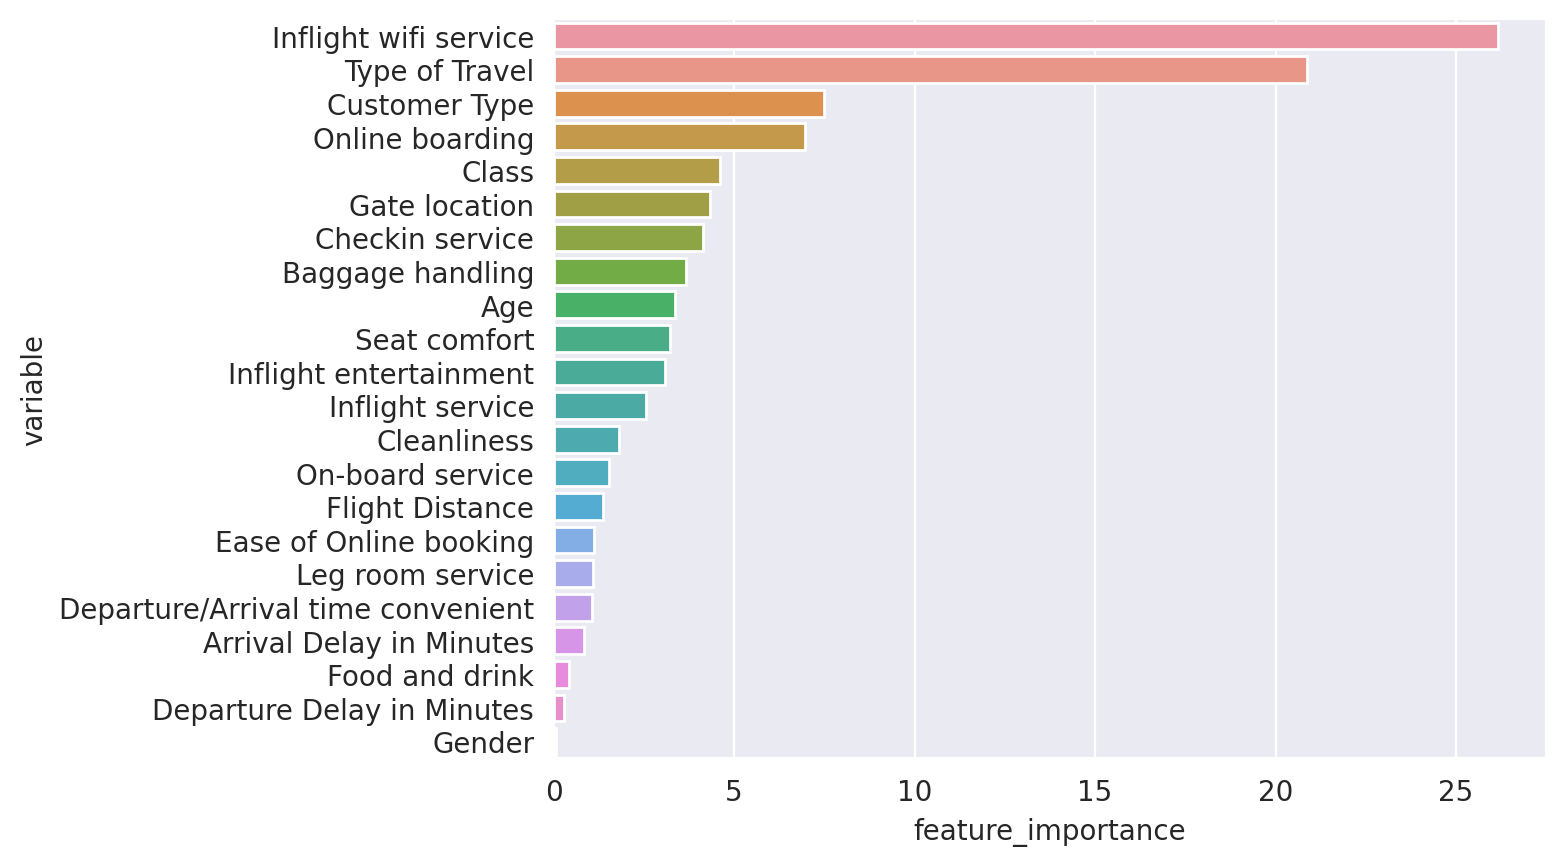

In [41]:
# CatBoost
cat_feature_imp=pd.DataFrame({'variable':X.columns,'feature_importance':model.get_feature_importance()}).sort_values('feature_importance',ascending=False).reset_index(drop=True)

sns.barplot(y=cat_feature_imp.variable,x=cat_feature_imp.feature_importance)

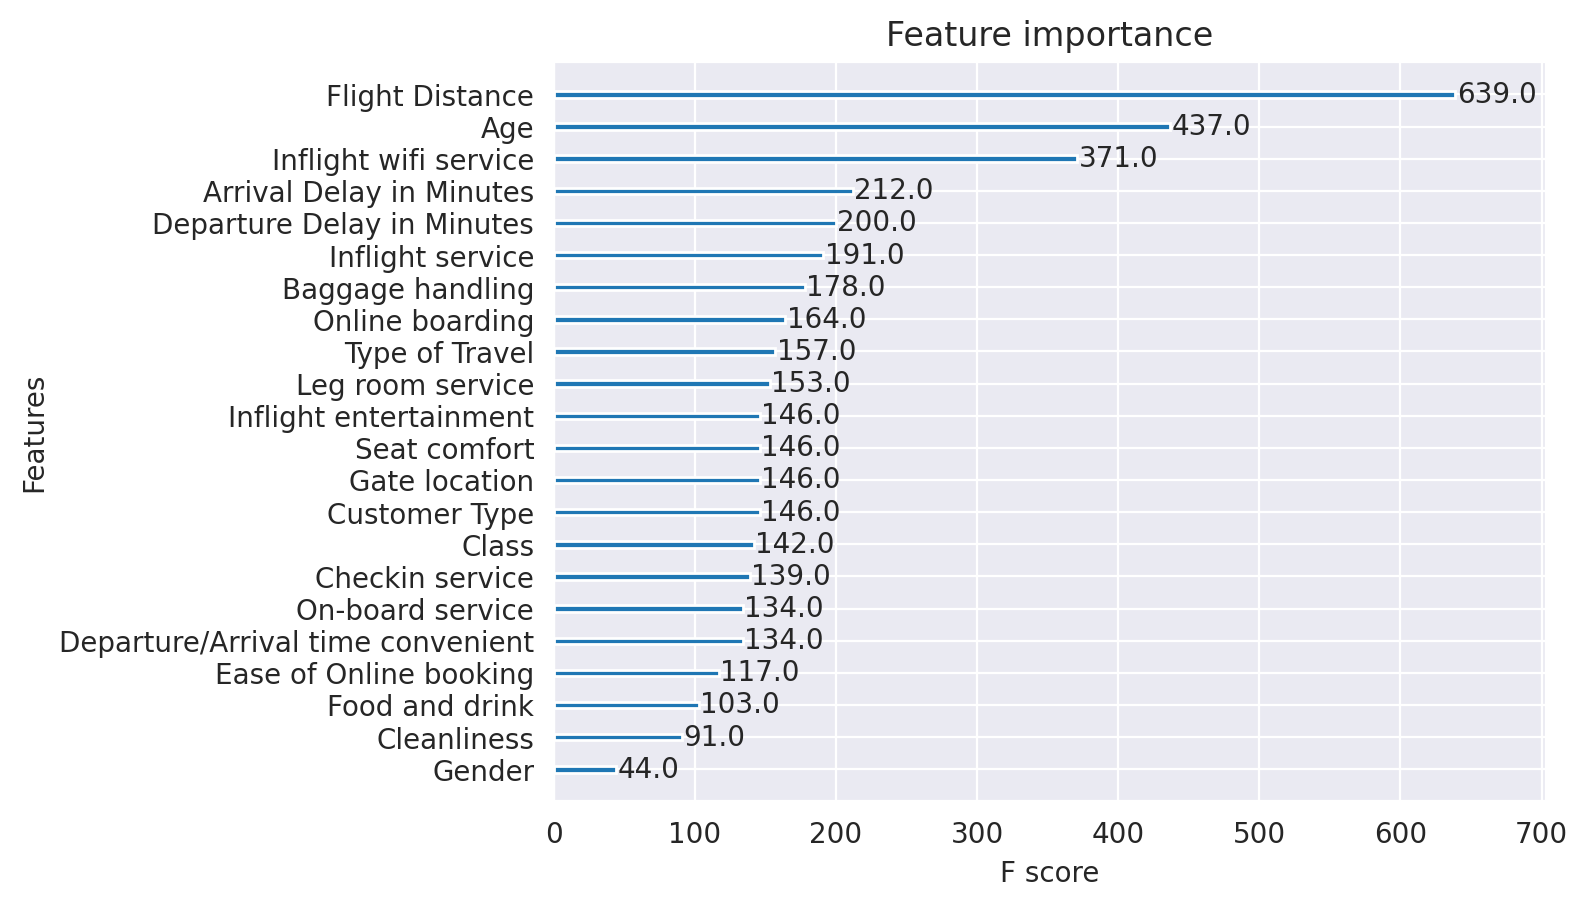

In [89]:
# XGBOOST
plot_importance(xgb)
plt.show()

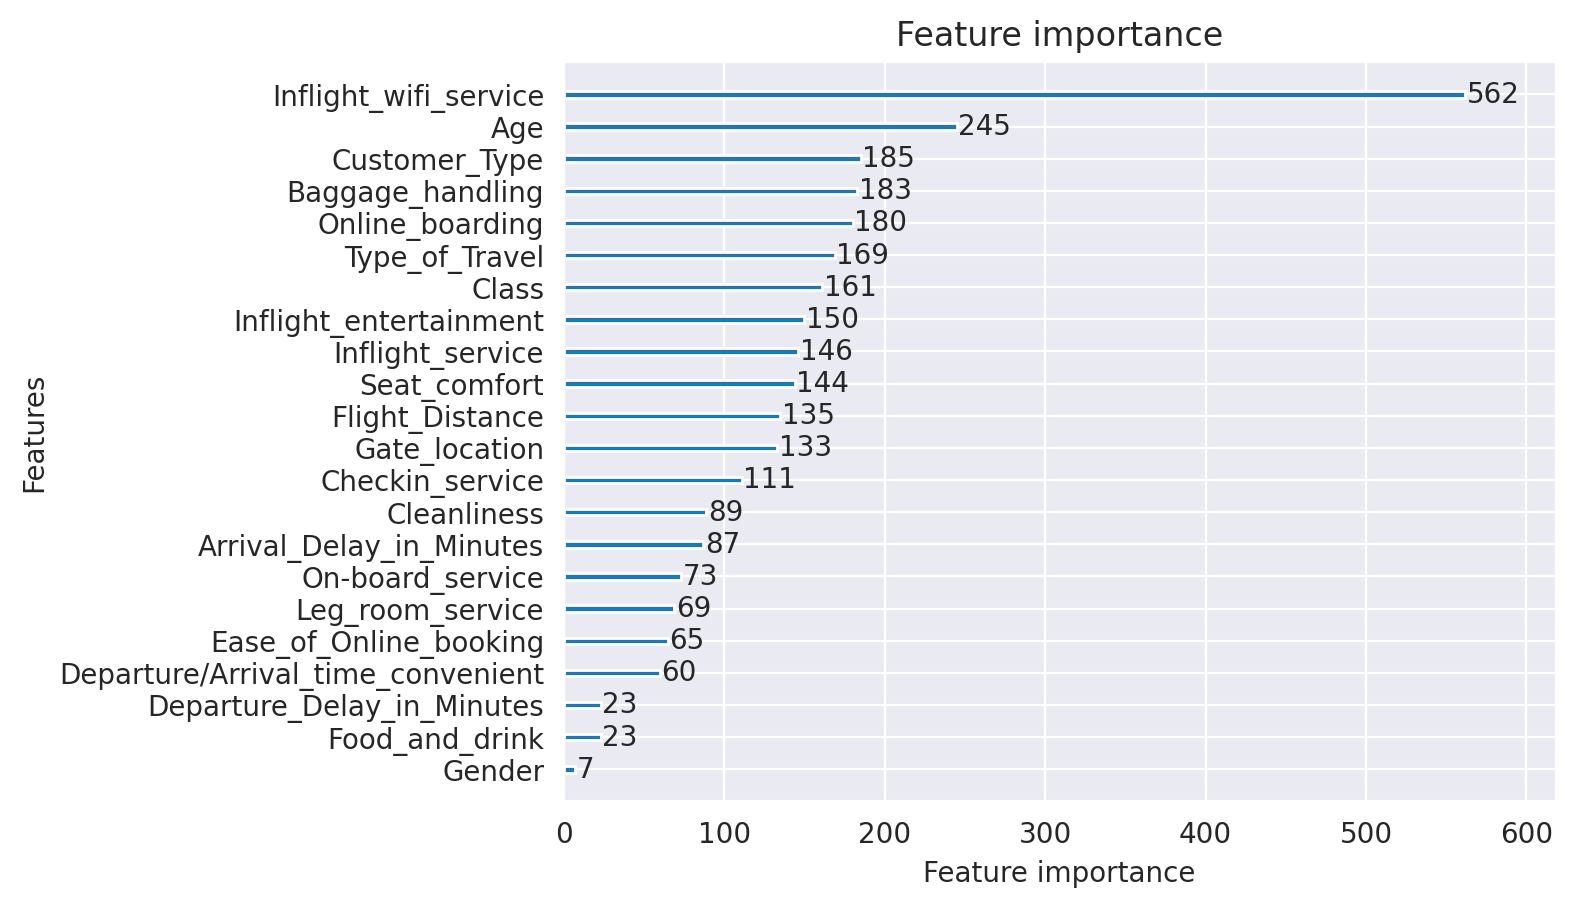

In [98]:
# LGBM
plot_importance(lgbm)
plt.show()


<AxesSubplot: xlabel='feature_importance', ylabel='variable'>

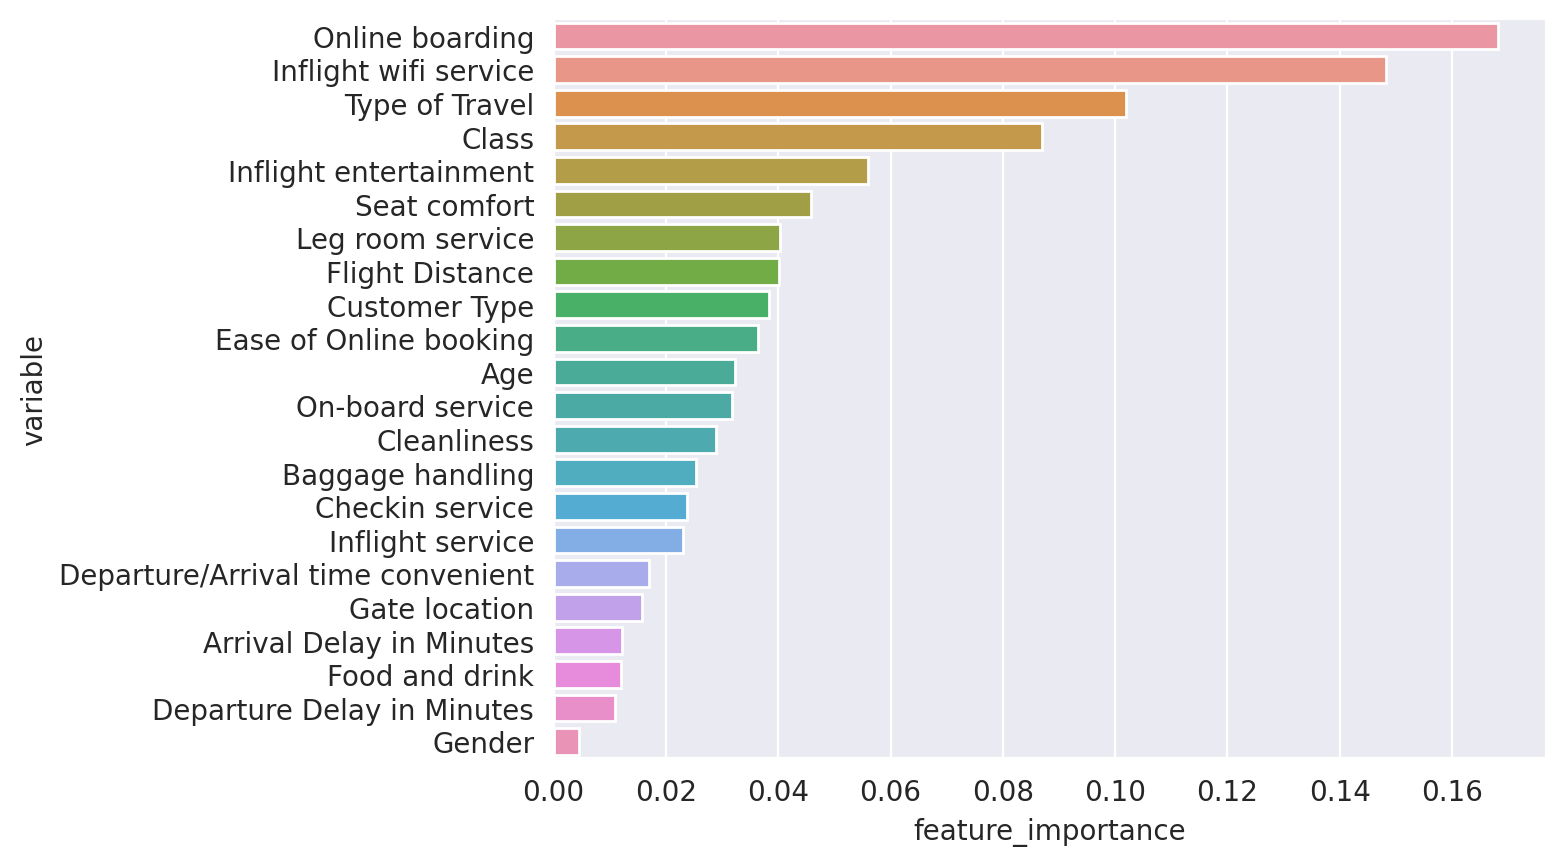

In [83]:
# RandomForest
rf_feature_imp=pd.DataFrame({'variable':X.columns,'feature_importance':rf.feature_importances_}).sort_values('feature_importance',ascending=False).reset_index(drop=True)

sns.barplot(y=rf_feature_imp.variable,x=rf_feature_imp.feature_importance)